In [1]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
import shap
from scipy.sparse import csr_matrix
from src.extraction.jsonl_data_reader import JsonlDataReader

seed = 7
random_state = RandomState(seed=seed)
np.random.seed(seed)
train_data = JsonlDataReader(file_name='train.jsonl').read()
dev_data = JsonlDataReader(file_name='dev.jsonl').read()
test_data = JsonlDataReader(file_name='test.jsonl').read()
from src.preprocessing.simple_preprocessor import SimplePreprocessor

preprocessor = SimplePreprocessor(remove_citations=False, remove_duplicates=False)
preprocessed_train = preprocessor.preprocess(train_data)
preprocessed_dev = preprocessor.preprocess(dev_data)
preprocessed_test = preprocessor.preprocess(test_data)
from src.tokenize.spacy_tokenizer import SpacyTokenizer

tokenizer = SpacyTokenizer(replace_numbers=True, remove_stopwords=False, merge_nouns=False, merge_entities=False,
                           lemmatize=False)
tokenized_train = tokenizer.tokenize(train_data)
tokenized_dev = tokenizer.tokenize(preprocessed_dev)
tokenized_test = tokenizer.tokenize(test_data)

from src.vectorizer.sk_tfidf_vectorizer import SkTfidfVectorizer

vectorizer = SkTfidfVectorizer(
    ngram_range=(1, 2), ignore_preprocessing=False,
    analyzer='word', binary=True
)
vectorizer.fit(tokenized_train)
vectorized_train = vectorizer.transform(tokenized_train)
vectorized_dev = vectorizer.transform(tokenized_dev)
vectorized_test = vectorizer.transform(tokenized_test)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support

model = LogisticRegression(max_iter=2000, C=10)
model.fit(vectorized_train.vectors, vectorized_train.label_indices)
y_pred_train = model.predict(vectorized_train.vectors)
training_score = f1_score(vectorized_train.label_indices, y_pred_train, average='macro')
print(f'{training_score=}')
print(confusion_matrix(vectorized_train.label_indices, y_pred_train))
print(precision_recall_fscore_support(vectorized_train.label_indices, y_pred_train, average='macro'))

y_pred_dev = model.predict(vectorized_dev.vectors)
dev_score = f1_score(vectorized_dev.label_indices, y_pred_dev, average='macro')
print(f'{dev_score=}')
print(confusion_matrix(vectorized_dev.label_indices, y_pred_dev))
print(precision_recall_fscore_support(vectorized_dev.label_indices, y_pred_dev, average='macro'))

y_pred_test = model.predict(vectorized_test.vectors)
testing_score = f1_score(vectorized_test.label_indices, y_pred_test, average='macro')
print(f'{testing_score=}')
print(confusion_matrix(vectorized_test.label_indices, y_pred_test))
print(precision_recall_fscore_support(vectorized_test.label_indices, y_pred_test, average='macro'))

training_score=0.9978193880384293
[[4834    5    1]
 [   5 2289    0]
 [   5    0 1104]]
(0.9982836713639273, 0.9973573884495986, 0.9978193880384293, None)
dev_score=0.8182162969395542
[[490  33  15]
 [ 62 187   6]
 [ 23   5  95]]
(0.8340835137986562, 0.8054905753518501, 0.8182162969395542, None)
testing_score=0.8241645391110555
[[870  62  65]
 [102 479  24]
 [ 33   7 219]]
(0.8169327313569607, 0.8366377454368701, 0.8241645391110555, None)


In [81]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
num_features = 10  # len(vectorizer.model.get_feature_names_out())
num_samples = 100
c = make_pipeline(vectorizer.model, model)
explainer = LimeTextExplainer(class_names=['background', 'method', 'result'])

In [82]:
plot_cases = {
    # Both correct
    35: 0,  # chosen
    37: 1,
    34: 2,
    
    # transformer correct
    76: 0,  # chosen
    47: 1, 
    193: 2,
    
    # classical correct
    286: 0,
    43: 1,
    866: 1,
    
    # None correct
    0: 0,
    32: 1,
    180: 2,
}

In [83]:
def save_lime_plot(index, correct_class):
    sampled_token = ' '.join(tokenized_test.tokens[index])
    exp = explainer.explain_instance(sampled_token, c.predict_proba, num_features=num_features, num_samples=num_samples, labels=[correct_class])
    # exp.save_to_file(f'test_{index}.html', predict_proba=True, show_predicted_value=True, labels=[correct_class])
    fig = exp.as_pyplot_figure(label=correct_class)
    fig.savefig(f'test_{index}.jpg')

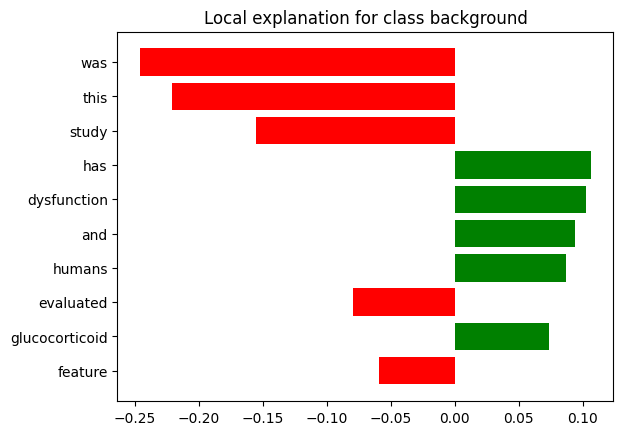

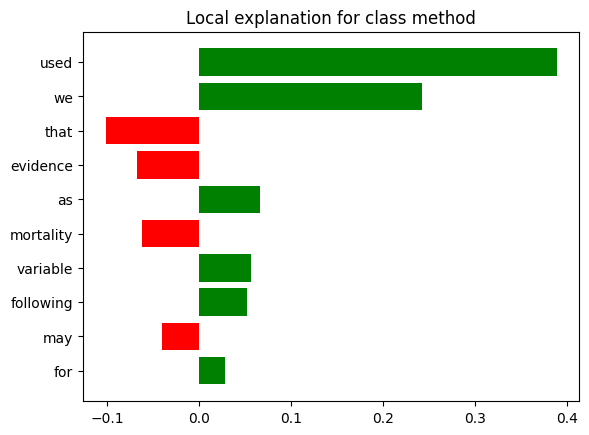

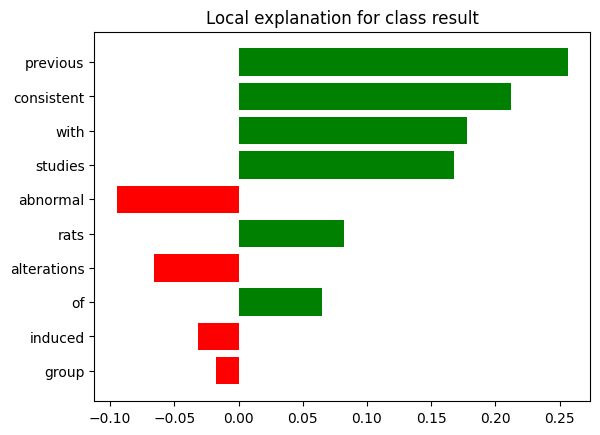

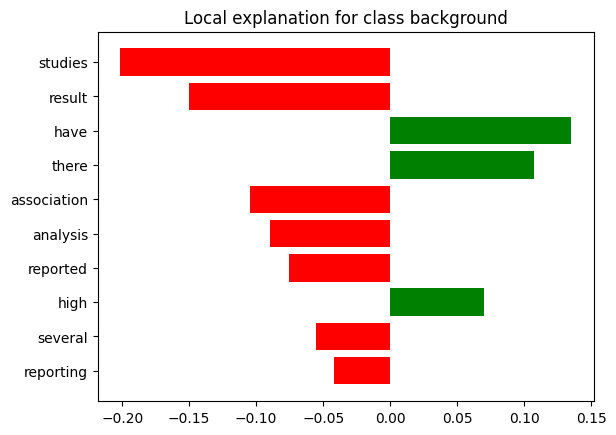

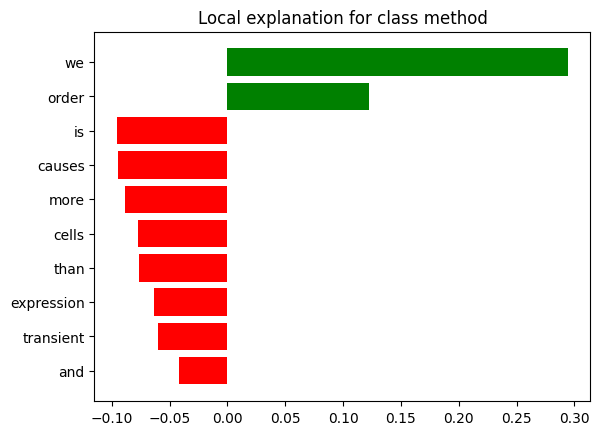

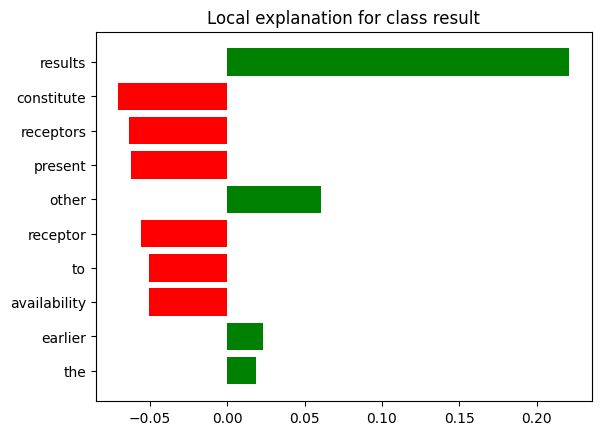

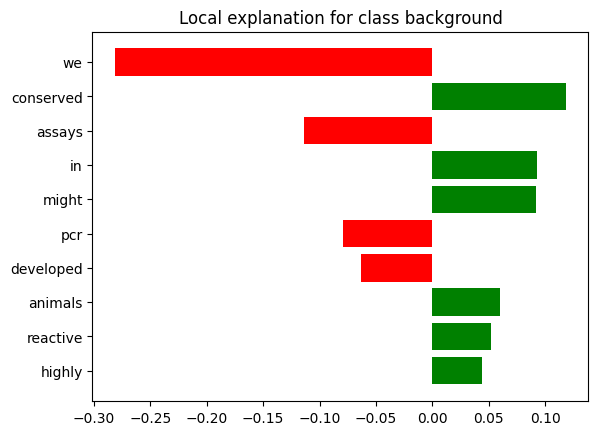

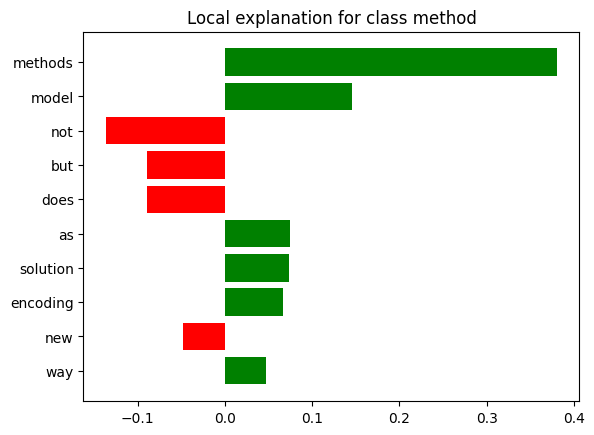

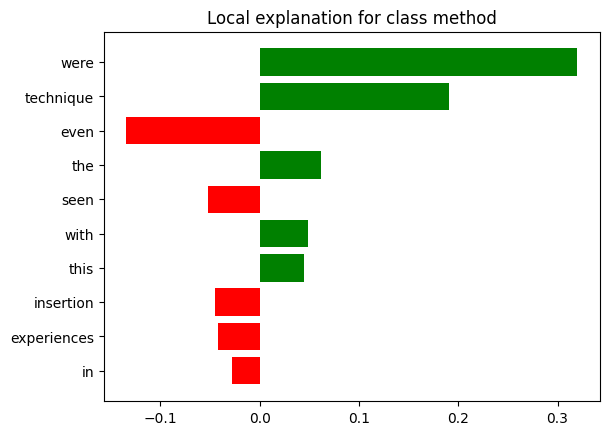

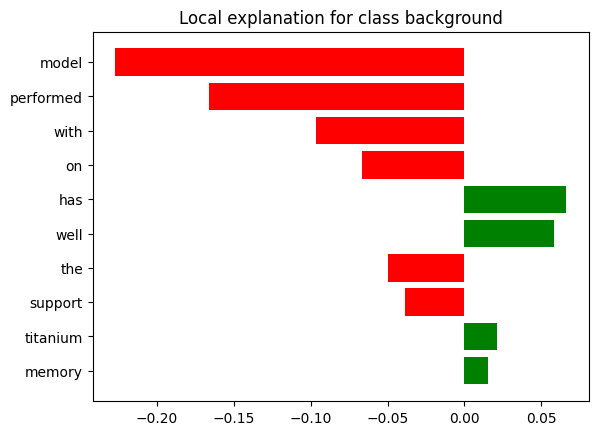

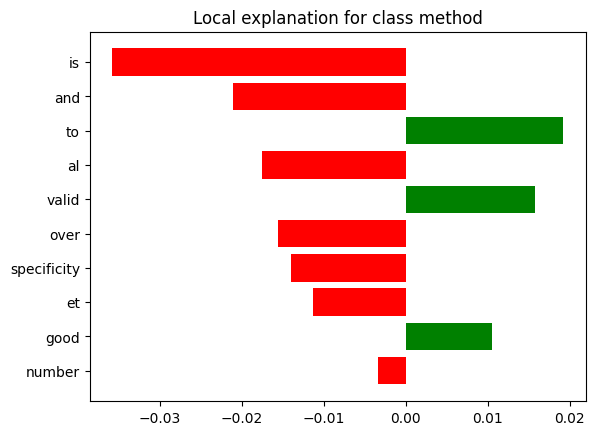

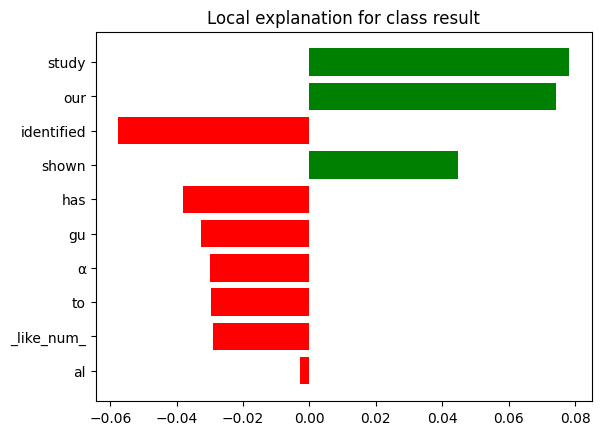

In [84]:
for index, correct_class in plot_cases.items():
    save_lime_plot(index, correct_class)

In [37]:
from src.utils.path_getter import PathGetter

merged_result = pd.read_csv(PathGetter.get_data_directory()/'classical_xlnet_2.csv', index_col=0)
merged_result = merged_result.reset_index()
merged_result

,index,pred_labels,true_labels,classical_pred
0,0,1,0,1
1,1,2,2,2
2,2,0,0,2
3,3,1,1,1
4,4,0,0,1
...,...,...,...,...
1856,1856,2,2,2
1857,1857,0,0,0
1858,1858,1,1,1
1859,1859,0,0,0


In [80]:
merged_result[merged_result.eval('pred_labels == true_labels & classical_pred != true_labels')]

,index,pred_labels,true_labels,classical_pred
2,2,0,0,2
4,4,0,0,1
5,5,1,1,0
9,9,1,1,0
13,13,2,2,0
...,...,...,...,...
1830,1830,0,0,2
1844,1844,0,0,1
1846,1846,1,1,0
1852,1852,1,1,0
